[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Singer_Ward/MWE_joss_paper.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Singer_Ward/MWE_joss_paper.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Singer_Ward/MWE_joss_paper.ipynb)

#### MWE for JOSSv2 paper code snippets

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM import Formulae
from PySDM.physics import si
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark

FORMULAE = Formulae()
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w
aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME)
formulae_bulk = Formulae(surface_tension='Constant')
formulae_ovad = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants={
        'sgm_org': 35 * si.mN / si.m,
        'delta_min': 1.75 * si.nm
    }
)
formulae_ruehl = Formulae(
    surface_tension='CompressedFilmRuehl',
    constants={
        'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_m_sigma': 0.3e17 * si.J / si.m**2,
        'RUEHL_sgm_min': 35 * si.mN / si.m
    }
)
formulae_sl = Formulae(
    surface_tension='SzyszkowskiLangmuir',
    constants={
        'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_sgm_min': 35 * si.mN / si.m
    }
)

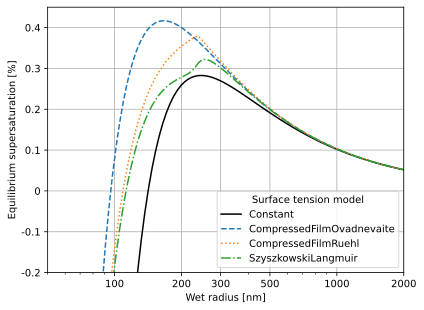

In [3]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
lines = {'Constant': '-', 'CompressedFilmOvadnevaite': '--', 'CompressedFilmRuehl': ':', 'SzyszkowskiLangmuir': '-.'}
colors = {'Constant': 'k', 'CompressedFilmOvadnevaite': 'C0', 'CompressedFilmRuehl': 'C1', 'SzyszkowskiLangmuir': 'C2'}

for formulae in (formulae_bulk, formulae_ovad, formulae_ruehl, formulae_sl):    
    r_wet = np.logspace(np.log(50 * si.nm), np.log(2000 * si.nm), base=np.e, num=100)
    sigma = np.ones(len(r_wet))
    for j,vw in enumerate(formulae_ovad.trivia.volume(r_wet)):
        sigma[j] = formulae.surface_tension.sigma(
            300 * si.K,
            vw,
            formulae_ovad.trivia.volume(50 * si.nm),
            aerosol.modes[0]['f_org']
        )
    RH_eq = formulae.hygroscopicity.RH_eq(
        r_wet,
        300 * si.K,
        aerosol.modes[0]['kappa'][formulae.surface_tension.__name__],
        (50 * si.nm)**3,
        sigma
    )
    model = formulae.surface_tension.__name__
    pyplot.plot(
        r_wet / si.nm,
        (RH_eq - 1)*100,
        label=f"{model}",
        color=colors[model],
        linestyle=lines[model]
    )
pyplot.grid()
pyplot.legend(title="Surface tension model", fontsize=10, loc=4)
pyplot.xscale('log')
r_wet_ticks_nm = (100, 200, 300, 500, 1000, 2000)
pyplot.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
pyplot.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pyplot.ylabel('Equilibrium supersaturation [%]')
yticks = (-.2, -.1, 0, .1, .2, .3, .4)
pyplot.yticks(yticks, yticks)
pyplot.ylim(yticks[0], .45)
pyplot.xlabel('Wet radius [nm]')
show_plot("Singer_fig1_kohler.pdf")